Test set accuracy: 0.93


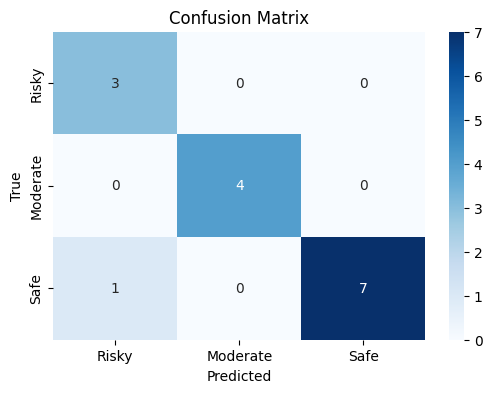

Classification Report:
              precision    recall  f1-score   support

       Risky       0.75      1.00      0.86         3
    Moderate       1.00      1.00      1.00         4
        Safe       1.00      0.88      0.93         8

    accuracy                           0.93        15
   macro avg       0.92      0.96      0.93        15
weighted avg       0.95      0.93      0.94        15



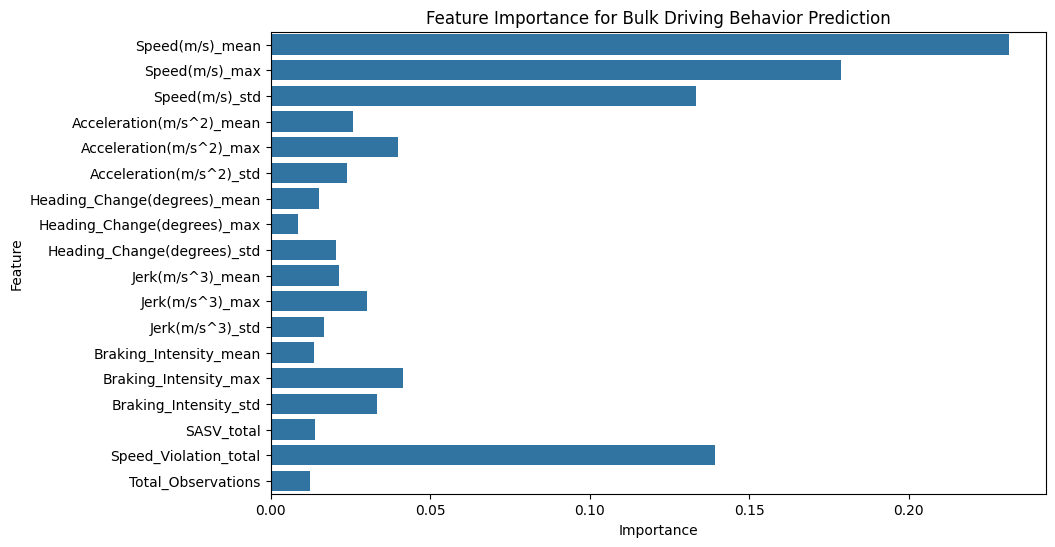

Model saved to ../models/bulk_driving_model.pkl


In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Load the bulk aggregated data
aggregated_data_path = '../data/bulk_driver_aggregated_data.csv'
df = pd.read_csv(aggregated_data_path)

# Feature selection
X = df[['Speed(m/s)_mean', 'Speed(m/s)_max', 'Speed(m/s)_std',
         'Acceleration(m/s^2)_mean', 'Acceleration(m/s^2)_max', 'Acceleration(m/s^2)_std',
         'Heading_Change(degrees)_mean', 'Heading_Change(degrees)_max', 'Heading_Change(degrees)_std',
         'Jerk(m/s^3)_mean', 'Jerk(m/s^3)_max', 'Jerk(m/s^3)_std',
         'Braking_Intensity_mean', 'Braking_Intensity_max', 'Braking_Intensity_std',
         'SASV_total', 'Speed_Violation_total', 'Total_Observations']]

y = df['Driving_Category'].map({'Risky': 0, 'Moderate': 1, 'Safe': 2})

# Handle class imbalance
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
scaler_path = '../models/bulk_scaler.pkl'
with open(scaler_path, 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Random Forest model with hyperparameter tuning
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Best model from grid search
best_rf = grid_search.best_estimator_

# Evaluate the model
y_pred = best_rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Risky', 'Moderate', 'Safe'], 
            yticklabels=['Risky', 'Moderate', 'Safe'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Risky', 'Moderate', 'Safe']))

# Feature Importance
feature_importances = best_rf.feature_importances_

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=X.columns)
plt.title('Feature Importance for Bulk Driving Behavior Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Save the trained model
model_filename = '../models/bulk_driving_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(best_rf, model_file)

print(f"Model saved to {model_filename}")
